<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Logo.png" alt="Instill Logo" width="300"/>

# Get Your PDF Files AI-Ready

In this notebook, we will leverage **Instill VDP** pipelines hosted on the **Instill Cloud** platform to transform PDF files into high-quality Markdown formatted text, suitable for AI applications.

### Why Does This Matter?

If you are building an AI or ML system, the level of performance you can achieve is almost entirely determined by the quality of the data you use to build or train that system: **Garbage In** $=$ **Garbage Out**. Oftentimes, you may want to build AI systems, such as RAG assistants or fine-tuned LLMs, using the information contained in documents such as PDF files. Despite their abundance throughout almost all organizations, PDF files are notoriously difficult to parse accurately due to the diversity of layouts, embedded images, charts, and non-standard fonts.

### Why Markdown?

Markdown is an ideal format for AI applications because it offers a balance between simplicity and structure. It provides a lightweight, human-readable way to represent documents while preserving essential formatting elements like headings, lists, and links. Unlike raw text, Markdown captures the document's hierarchy and formatting in a clear, organized manner, making it easier for AI models to extract meaning and context.

To learn more about document parsing for AI and RAG applications, please checkout our blog post 👉 [here](https://www.instill.tech/blog/make-complex-documents-rag-ready).

### Flexibility Based on Document Complexity, Latency, and Cost

There’s no one-size-fits-all solution for parsing PDF documents into Markdown because every document is different. Some may have simple text and formatting, while others include intricate tables, images, or specialized formatting like mathematical equations. A PDF could even be a scanned hand-written note. Depending on the complexity of the document, we provide multiple approaches, allowing you to choose the best method for your particular use case:

1. **Fast Heuristic Parsing** of PDF/DOCX/DOC/PPTX/PPT/HTML/XLSX into Markdown using our hand-crafted [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown).
2. **LLM-Refined Parsing** with our [pipeline](https://instill.tech/george_strong/pipelines/llm-corrected-pdf-to-markdown/playground) that leverages a LLM (GPT-4o-mini) to supervise and improve the formatting of Markdown output generated by the Document Operator.
3. **Hybrid Multimodal Parsing** using our flagship [pipeline](https://instill.tech/instill-ai/pipelines/adv-complex-doc-parser/playground?version=v2.0.0) that combines the output of our heuristic Document Operator with OpenAI's GPT-4o visual-language model (VLM) for refinement.

Before we go any further, try our **Hybrid Multimodal Parsing** pipeline yourself on our free demo page below!

In [1]:
from IPython.display import IFrame
IFrame('https://www.instill.tech/demos/document-parser-gen-ai', width=1100, height=700)

In this notebook, we will demonstrate how to use each of these methods via our Python SDK. The PDF document we will be demonstrating on is the famous [AlexNet paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

### Setup

To execute all of the code in this notebook, you’ll need to create a free Instill Cloud account and setup an API Token. To create your account, please refer to our [quickstart guide](https://www.instill.tech/docs/quickstart). For generating your API Token, consult the [API Token Management](https://www.instill.tech/docs/core/token) page.

**This will give you access to 10,000 free credits per month that you can use to make API calls with third-party AI vendors. Please see our [documentation](https://www.instill.tech/docs/cloud/credit) for further details.**

We will now install the latest Instill Python SDK, import the required libraries, and configure the SDK with a valid API token.

In [2]:
!pip install instill-sdk==0.15.1 --quiet

In [ ]:
import base64
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt
import math

from instill.clients import init_pipeline_client
pipeline = init_pipeline_client(api_token="YOUR_INSTILL_API_TOKEN")

Let's download and base64 encode the [AlexNet PDF](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) file we will be converting to Markdown-formatted text.

In [4]:
alexnet_paper = "https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf"

alexnet_response = requests.get(alexnet_paper)
alexnet_base64 = base64.b64encode(alexnet_response.content).decode('utf-8')

### 1. Fast Heuristic Parsing 

First, we will transform the PDF file into Markdown using the **Instill Component** [Document Operator](https://www.instill.tech/docs/component/operator/document). This is the fastest, cheapest, and lowest latency option available. To implement this, we will be using the [standard-doc-to-markdown](https://instill.tech/george_strong/pipelines/standard-doc-to-markdown/playground) pipeline. 

In [5]:
response = pipeline.trigger(
    namespace_id="george_strong",
    pipeline_id="standard-doc-to-markdown",
    data=[{"file": alexnet_base64}]
)

In [6]:
md_text = response.outputs[0].fields['markdown'].string_value
print(md_text)

# ImageNet   Classification with Deep Convolutional Neural Networks

   Alex Krizhevsky   Ilya Sutskever   Geoffrey E. Hinton
  University of Toronto University of Toronto University of Toronto
kriz@cs.utoronto.ca ilya@cs.utoronto.ca hinton@cs.utoronto.ca

                 Abstract

   We trained a large, deep convolutional neural network to classify the 1.2 million
   high-resolution images in the ImageNet LSVRC-2010 contest into the 1000 dif-
   ferent classes. On the test data, we achieved top-1 and top-5 error rates of 37.5%
   and 17.0% which is considerably better than the previous state-of-the-art. The
   neural network, which has 60 million parameters and 650,000 neurons, consists
   of five convolutional layers, some of which are followed by max-pooling layers,
   and three fully-connected layers with a final 1000-way softmax. To make train-
   ing faster, we used non-saturating neurons and a very efficient GPU implemen-
   tation of the convolution operation. To reduce overfi

In addition to the Markdown-formatted text output, the [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown) also outputs images that have been extracted. Image extraction in the Document Operator naturally prefers recall over precision, as this ensures that all potentially relevant images are captured during processing, even at the risk of including non-essential images. This approach prioritizes thoroughness in the extraction phase, which can later be refined if necessary.

In [7]:
images = response.outputs[0].fields['images'].list_value.values

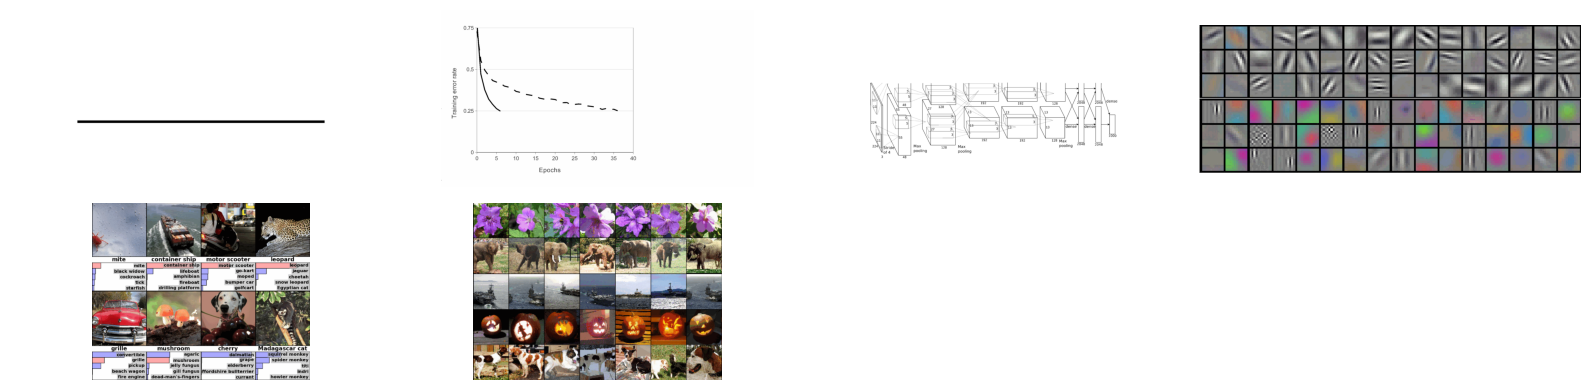

In [8]:
def plot_images(image_urls, images_per_row=4):
    num_images = len(image_urls)
    num_rows = math.ceil(num_images / images_per_row)

    plt.figure(figsize=(images_per_row * 4, num_rows * 2))

    for i, url in enumerate(image_urls):
        try:
            response = requests.get(url.string_value)
            
            image_data = io.BytesIO(response.content)
            image = Image.open(image_data)

            plt.subplot(num_rows, images_per_row, i + 1)
            plt.imshow(image)
            plt.axis('off')
        except Exception as e:
            print(f"Failed to load image from {url}: {e}")
    
    plt.tight_layout()
    plt.show()

plot_images(images, images_per_row=4)

### 2. LLM-Refined Parsing

We will now use the [Document Operator](https://www.instill.tech/docs/component/operator/document#convert-to-markdown) in tandem with a LLM whose task is to supervise and improve the formatting of Markdown output previously generated by the Document Operator. Checkout the pipeline preview page below for additional context.

In [9]:
IFrame('https://instill.tech/george_strong/pipelines/llm-corrected-pdf-to-markdown/preview', width=1000, height=700)

In [10]:
response = pipeline.trigger(
    namespace_id="george_strong",
    pipeline_id="llm-corrected-pdf-to-markdown",
    data=[{"document_input": alexnet_base64}]
)

In [11]:
md_text = response.outputs[0].fields['markdown'].string_value
print(md_text)

# ImageNet Classification with Deep Convolutional Neural Networks

Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton  
University of Toronto, University of Toronto, University of Toronto  
kriz@cs.utoronto.ca, ilya@cs.utoronto.ca, hinton@cs.utoronto.ca

## Abstract

We trained a large, deep convolutional neural network to classify the 1.2 million high-resolution images in the ImageNet LSVRC-2010 contest into the 1000 different classes. On the test data, we achieved top-1 and top-5 error rates of 37.5% and 17.0%, which is considerably better than the previous state-of-the-art. The neural network, which has 60 million parameters and 650,000 neurons, consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax. To make training faster, we used non-saturating neurons and a very efficient GPU implementation of the convolution operation. To reduce overfitting in the fully-connected layers, we employe

### 3. Hybrid Multimodal Parsing

This is one of our more advanced pipelines for parsing even the most complex documents. Here's a diagram of how it works:

<img src="https://raw.githubusercontent.com/instill-ai/cookbook/main/images/Doc_parse_flow.png" alt="Hybrid Multimodal Parsing" width="600"/>

Here's a more detailed walkthrough of the key stages displayed in this diagram:

1. **Document-to-Image Conversion:** The pipeline begins by converting the pages of the document into high-resolution images (300 DPI). This enables it to capture the visual layout and implicit hierarchies often overlooked by heuristic methods.

2. **Parsing with Document Operator:** Simultaneously, the pipeline processes the document using our heuristics-based Document Operator to generate an initial Markdown draft. This provides a structured textual representation of the document, offering a solid starting point for further refinement.

3. **Batch Processing for Parallelization:** The images and Markdown drafts are split into manageable batches, typically groups of four. This enables efficient parallel processing, speeding up the pipeline, maintaining alignment between images and text, and providing improved formatting consistency between pages.

4. **Refinement with Visual Language Models (VLMs):** Each batch of Markdown is paired with its corresponding batch of images, and these batches are then fed, in parallel, to a Visual Language Model. The VLM iteratively enhances each batch of Markdown by:
   - Correcting inaccuracies in text formatting and structure.
   - Formatting complex elements like tables.
   - Adding descriptive details for visual elements (e.g., images or diagrams).
   - Ensuring coherence and completeness across the content.

5. **Fallback Mechanism with Document OCR:** In cases where an initial Markdown draft cannot be generated (e.g., scanned PDFs or non-textual documents), the pipeline activates a document-level OCR fallback process. This extracts text directly from the high-resolution images.

6. **Final Integration:** Refined Markdown batches are merged into a cohesive and rich output, resulting in a complete and well-structured representation of the original document.

In [12]:
response = pipeline.trigger_release(
    namespace_id="instill-ai",
    pipeline_id="adv-complex-doc-parser",
    release_id="v2.0.0",
    data=[{"document_input": alexnet_base64}]
)

In [19]:
md_text = response.outputs[0].fields['convert_result'].string_value
print(md_text)

# ImageNet Classification with Deep Convolutional Neural Networks

Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton  
University of Toronto  
kriz@cs.utoronto.ca, ilya@cs.utoronto.ca, hinton@cs.utoronto.ca

## Abstract

We trained a large, deep convolutional neural network to classify the 1.2 million high-resolution images in the ImageNet LSVRC-2010 contest into the 1000 different classes. On the test data, we achieved top-1 and top-5 error rates of 37.5% and 17.0% which is considerably better than the previous state-of-the-art. The neural network, which has 60 million parameters and 650,000 neurons, consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax. To make training faster, we used non-saturating neurons and a very efficient GPU implementation of the convolution operation. To reduce overfitting in the fully-connected layers we employed a recently-developed regularization method cal

In [20]:
pipeline.close()